# Tasty Bytes - Predicting High-Traffic Recipes

### Data Validation
The data set has 947 rows and 8 columns. Preliminary check shows the following:

**recipe:** unique identifier of recipe with dtype int64. No missing values. No cleaning needed.<br>
**calories, carbohydrate, sugar, protein:** No. of calories and amount of carbohydrate, sugar and protein in grams with dtype float64. 52 missing values not at random.<br>
**category:** type of recipe with dtype object. Recipes should have one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'). There are recipes that have 'Chicken Breast' as category. These will be amended as 'Chicken'.<br>
**servings:** number of servings for the recipe with dtype object. It looks like it should be numeric.<br>
**high traffic:** marked "High" (dtype object) if traffic was high when this recipe was shown. 373 missing values, likely to represent "Low" traffic.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv("recipe_site_traffic_2212.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [5]:
# Check categorical variables for duplicate values, errors and consistency
unique_categoies = df["category"].value_counts()
unique_traffic = df["high_traffic"].value_counts()
unique_servings = df["servings"].value_counts()

unique_categoies, unique_servings, unique_traffic

(Breakfast         106
 Chicken Breast     98
 Beverages          92
 Lunch/Snacks       89
 Potato             88
 Pork               84
 Vegetable          83
 Dessert            83
 Meat               79
 Chicken            74
 One Dish Meal      71
 Name: category, dtype: int64,
 4               389
 6               197
 2               183
 1               175
 4 as a snack      2
 6 as a snack      1
 Name: servings, dtype: int64,
 High    574
 Name: high_traffic, dtype: int64)

### Cleaning steps
1. Under "category", amend "Chicken Breast" to "Chicken".
2. Clean "servings" by extracting numeric portion and convert to int.
3. Nutritional values are missing not at random. Since they account for less than 5% of the dataset, they will be dropped.
4. For completeness, fill null values under "high_traffic" with "Low".

In [6]:
# Amend "Chicken Breast" to "Chicken"
df.loc[df['category'] == 'Chicken Breast', 'category'] = 'Chicken'

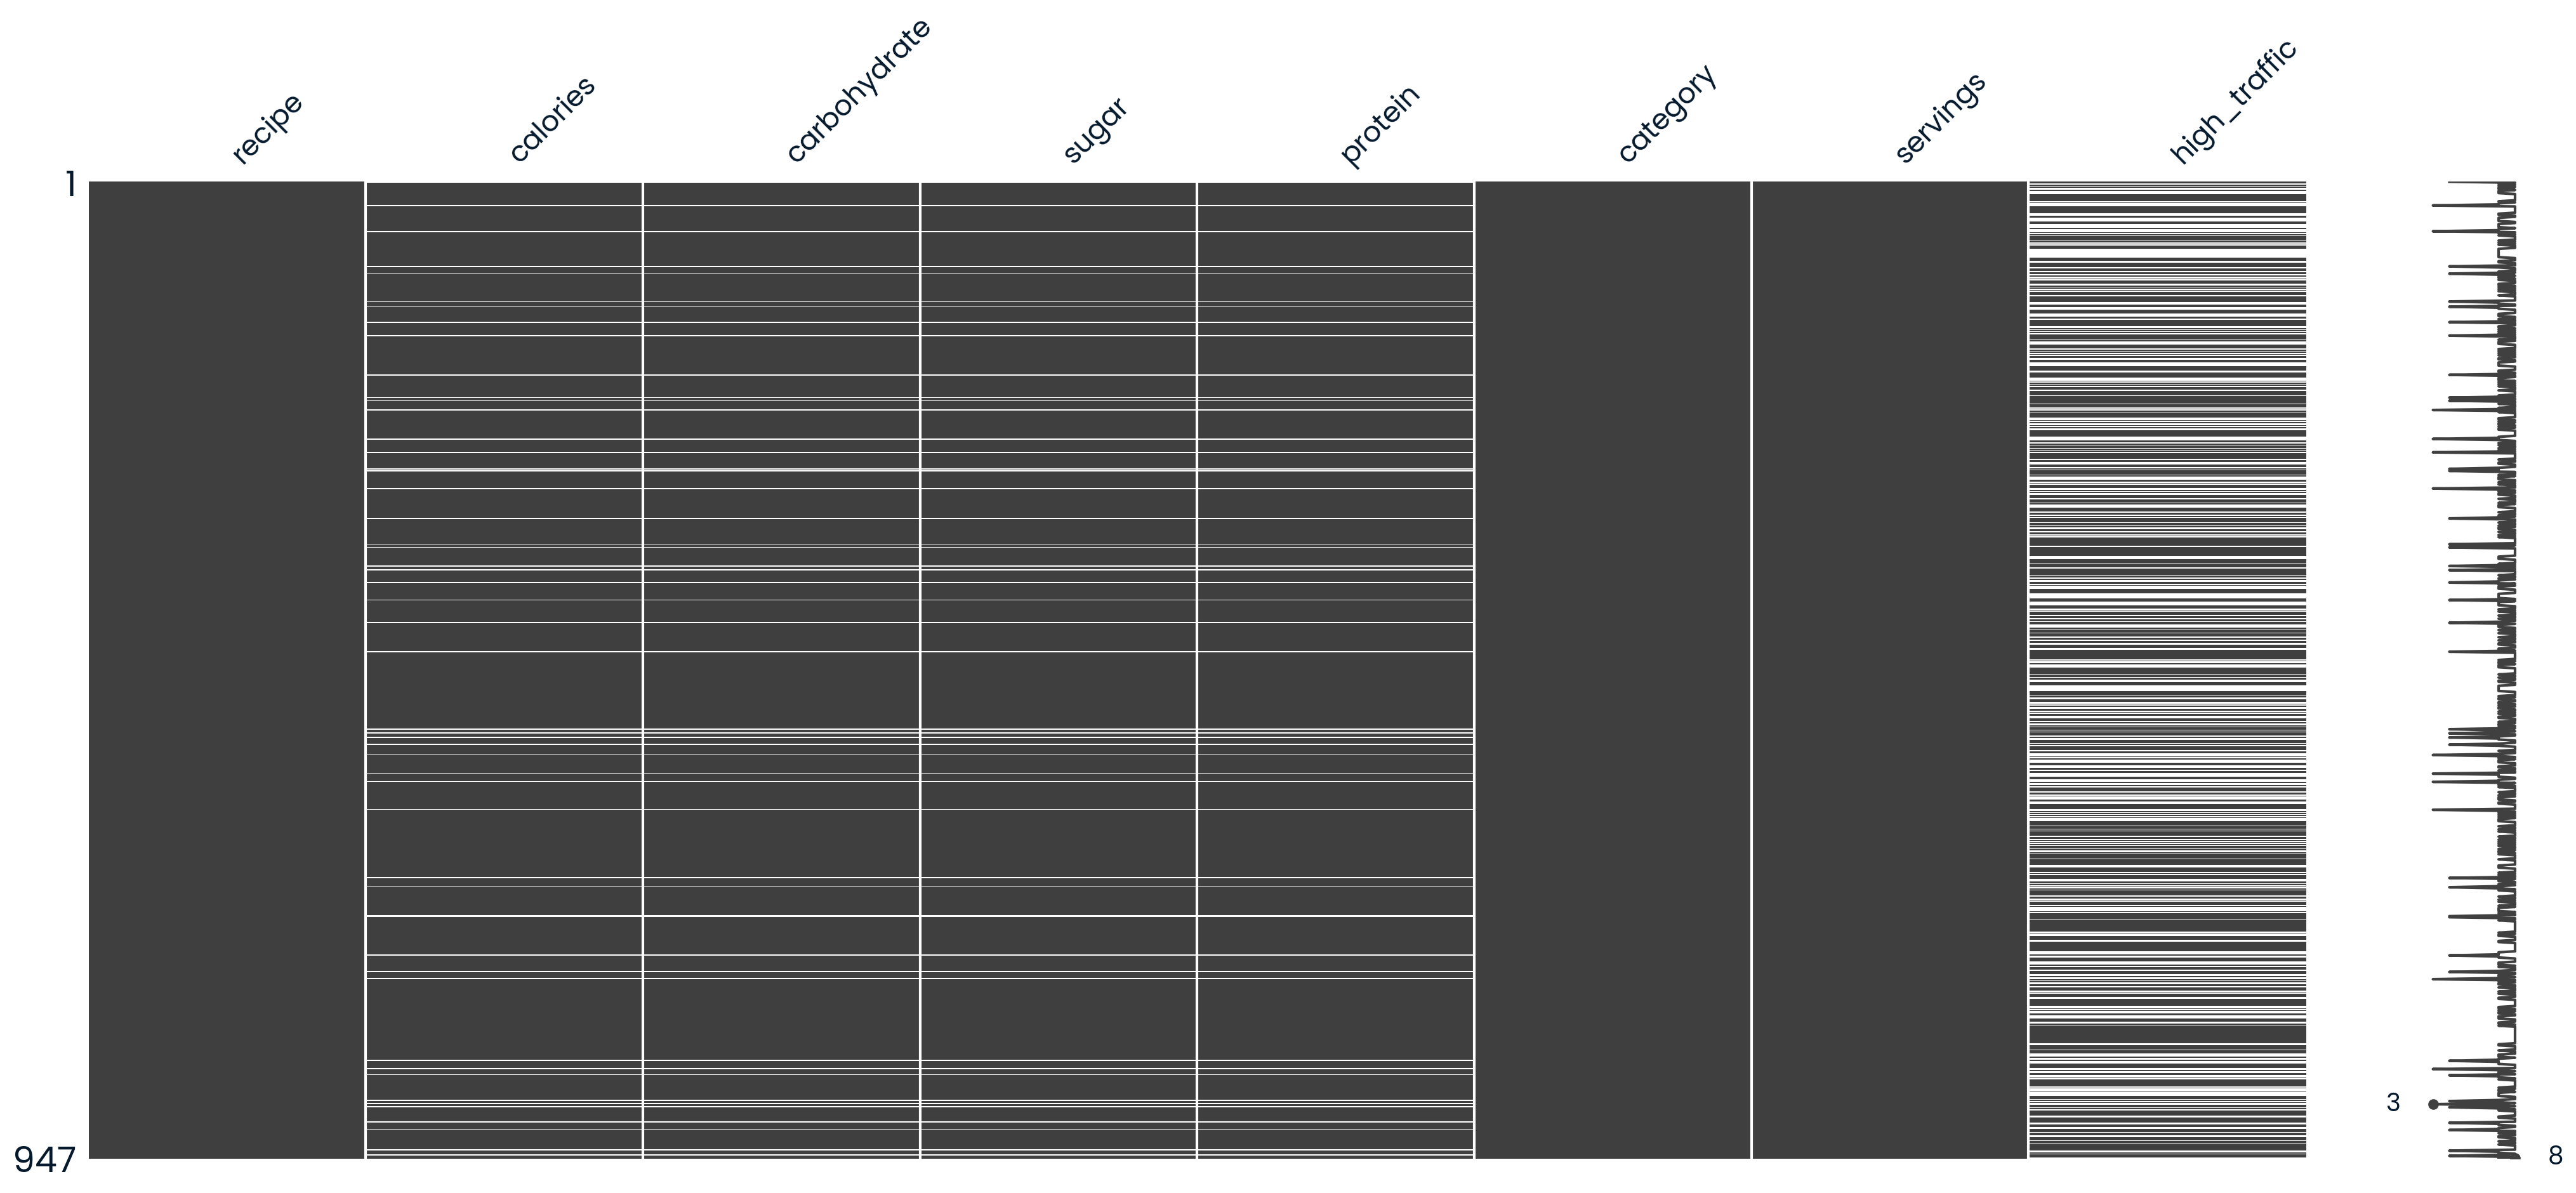

In [7]:
# Check if missing values are not at random, or at random or completely at random.
import missingno as msno

msno.matrix(df)
plt.show()

In [8]:
# Drop missing values since they are MNAR and accounts for less than 5% of the dataset.
df = df.dropna(subset = ['calories','carbohydrate','sugar','protein'])

In [9]:
# Extract numeric portion of 'servings' and convert to int
df['servings'] = df['servings'].astype(str).str.extract(r'(\d+)')[0].astype(float).astype(int)

# Fill null values in "high_traffic" with "Low" and convert to binary ("High" = 1, "Low" = 0)
df['high_traffic'].fillna('Low', inplace=True)
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)


# Check for duplicates
duplicates = df.duplicated().sum()

# Final check
duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        895 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      895 non-null    object 
 6   servings      895 non-null    int64  
 7   high_traffic  895 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 62.9+ KB


## Exploratory Data Analysis

The variance for the different variable varies slightly, suggesting a need for transformation / standardization before modelling.

In [10]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101,0.597765
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979,0.490623
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000,0.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000,1.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000,1.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


### 1. Distribution of calories
The distribution of calorie is right-skewed, suggesting that most recipes have lower calorie counts, with a few outliers having very high calories. This indicates that most recipes are relatively low-calorie, with a small number of high-calorie recipes.

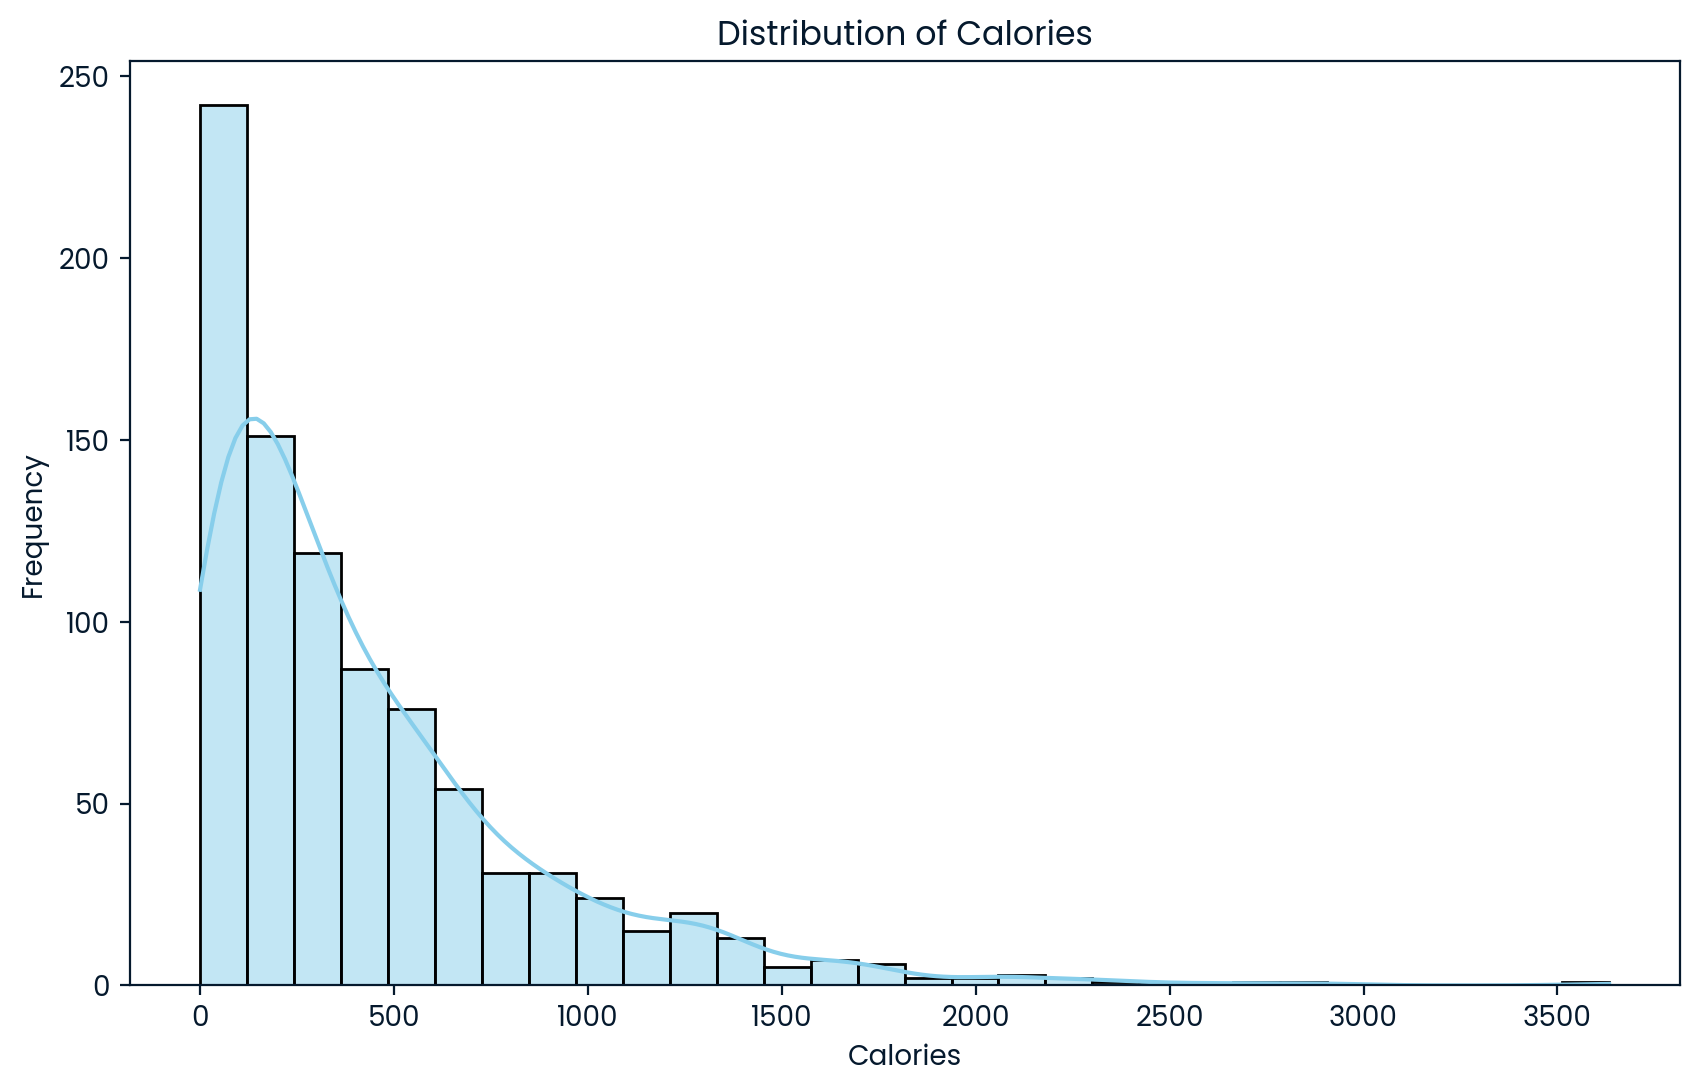

In [11]:
# Distribution of calorie
plt.figure(figsize=(10, 6))
sns.histplot(df['calories'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

### 2. Recipe category count
The dataset contains recipes from various categories, with some categories (e.g., "Chicken", "Breakfast") being more frequent than others. This indicates that certain types of recipes are more common in the dataset.

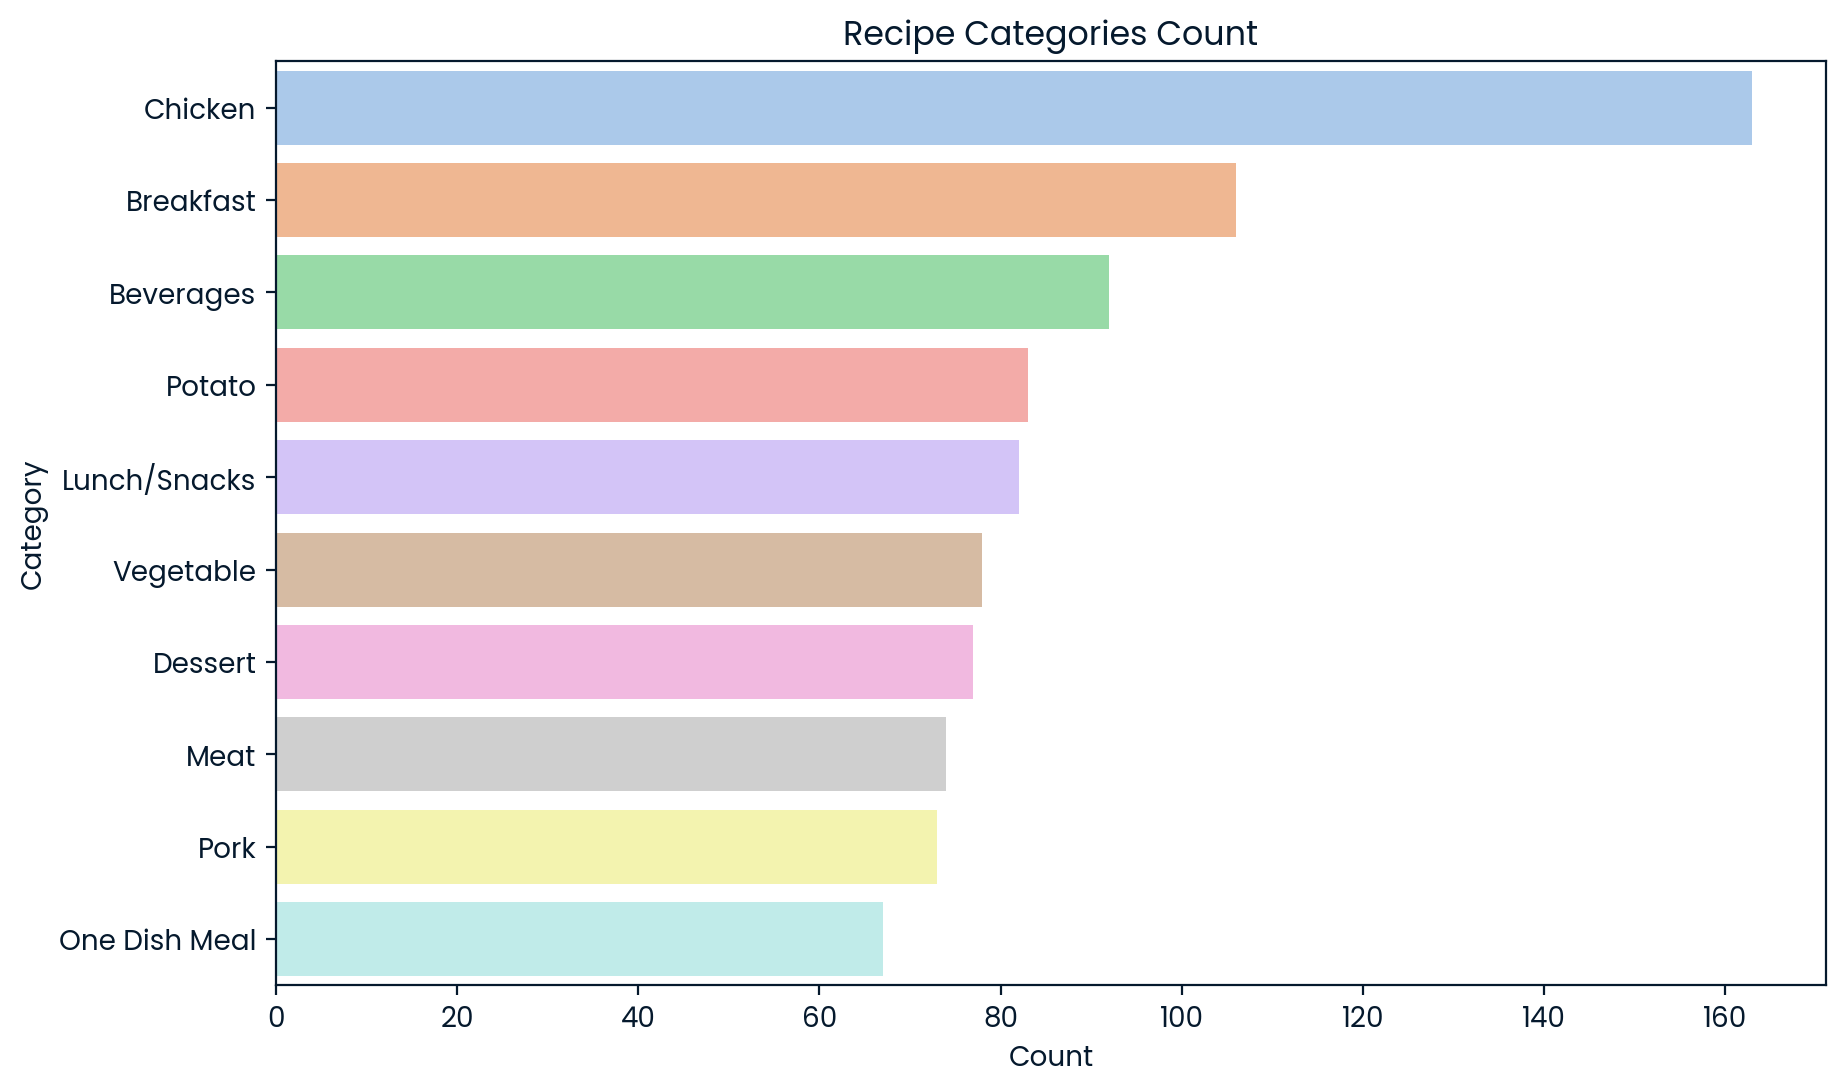

In [12]:
# Bar plot of recipe categories
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='pastel')
plt.title('Recipe Categories Count')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

### 3. Spread of carbohydrate, protein, sugar
**Carbohydrate:** The spread is wide, with many outliers on the higher end. This suggests that some recipes are very high in carbohydrates.<br>
**Protein:** The spread is narrower compared to carbohydrates, with fewer outliers. Most recipes have moderate protein content.<br>
**Sugar:** The spread is relatively narrow, but there are some outliers with very high sugar content.

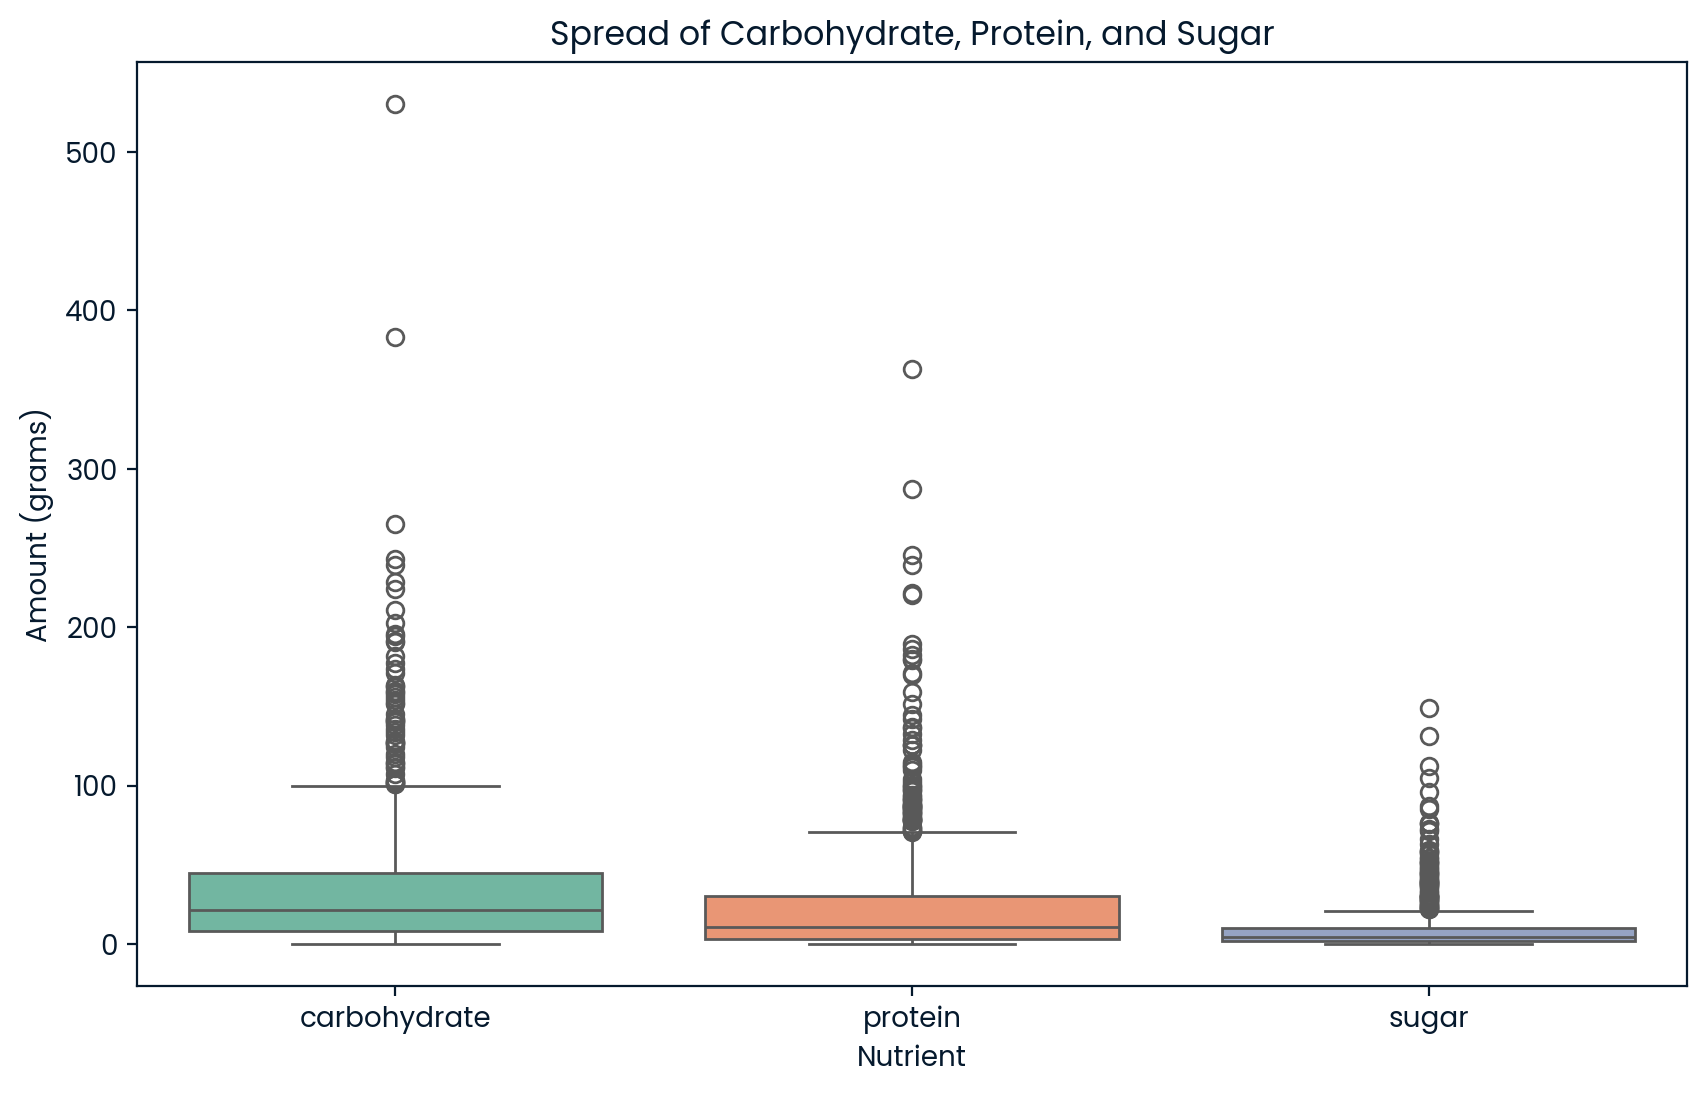

In [13]:
# boxplot for carbohydrate, protein, sugar
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['carbohydrate', 'protein', 'sugar']], palette='Set2')
plt.title('Spread of Carbohydrate, Protein, and Sugar')
plt.xlabel('Nutrient')
plt.ylabel('Amount (grams)')
plt.show()

### 4. Traffic VS calories
"High" traffic recipes tend to have more varied calorie counts, but not dramatically different from "Low".

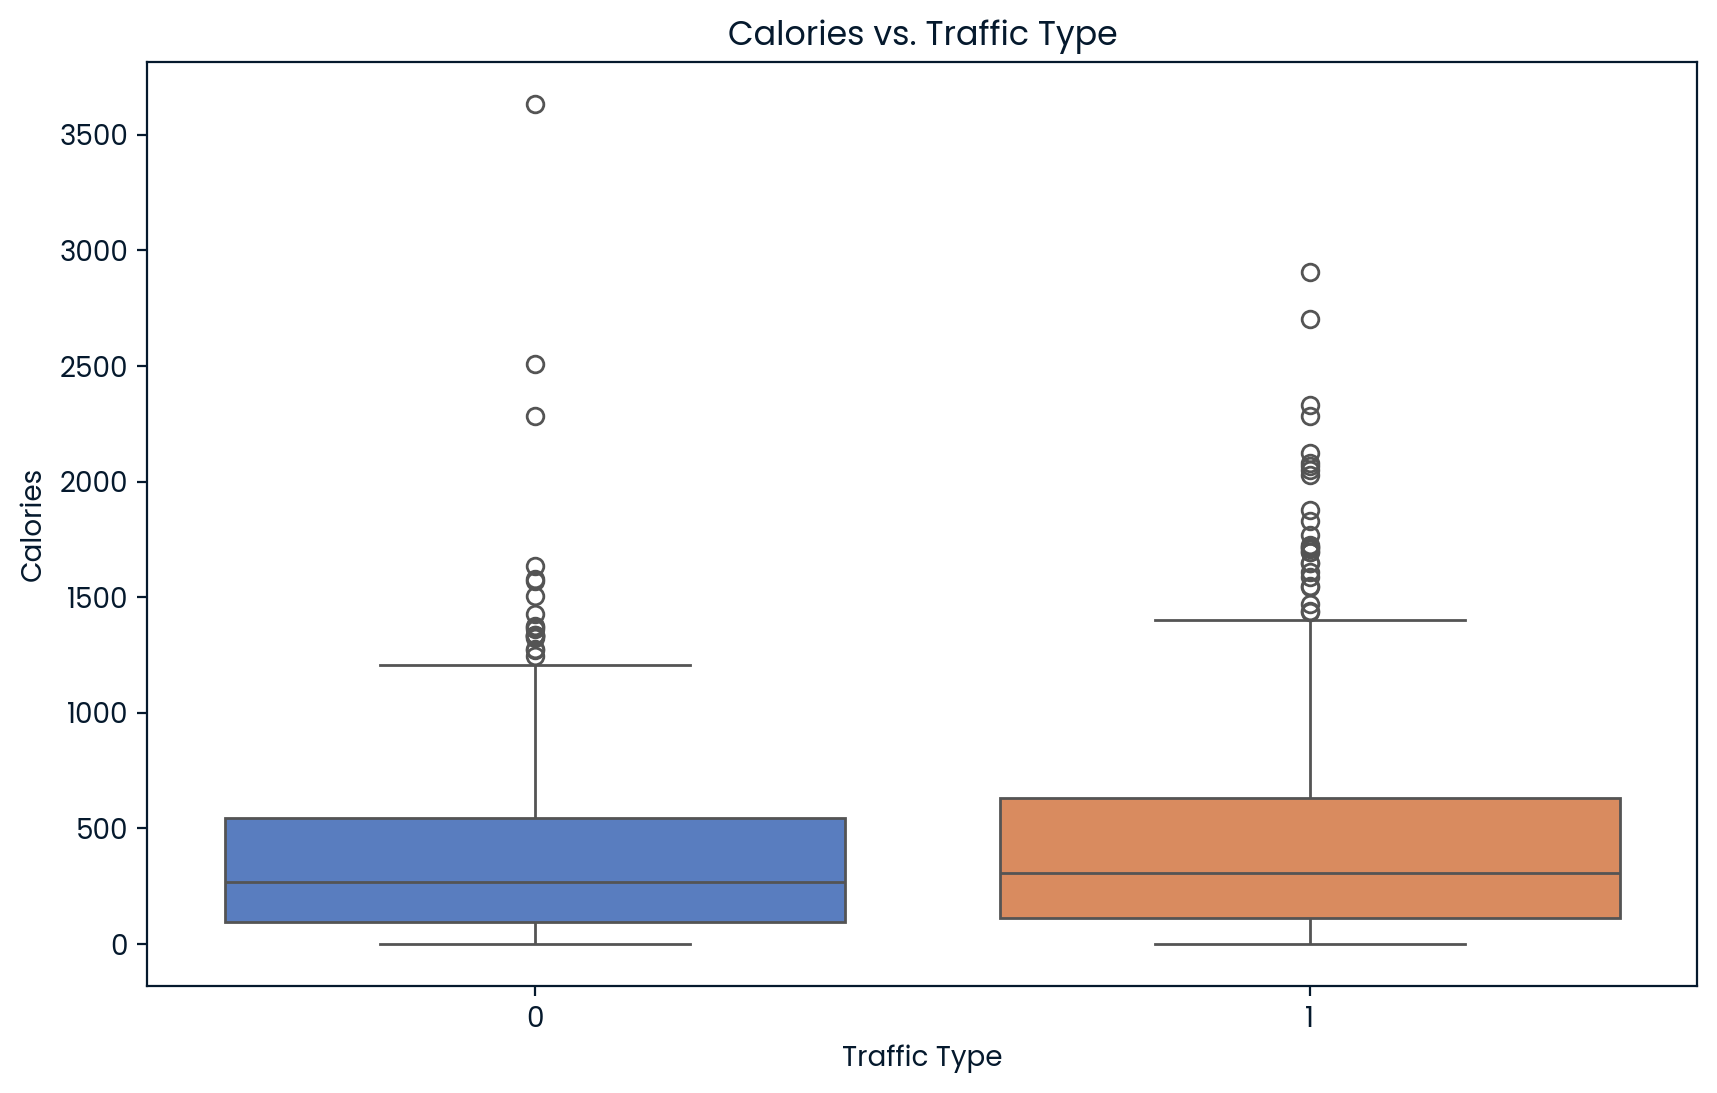

In [14]:
# Calories vs. Traffic
plt.figure(figsize=(10, 6))
sns.boxplot(x='high_traffic', y='calories', data=df, palette='muted')
plt.title('Calories vs. Traffic Type')
plt.xlabel('Traffic Type')
plt.ylabel('Calories')
plt.show()

### 5. Heatmap of correlation matrix

The heatmap shows correlations between numerical variables (e.g., calories, carbohydrate, sugar, protein). There is a moderate positive correlation between calories and protein, as seen in the scatter plot. Other correlations (e.g., carbohydrate and sugar) are also visible, indicating relationships between nutritional components.

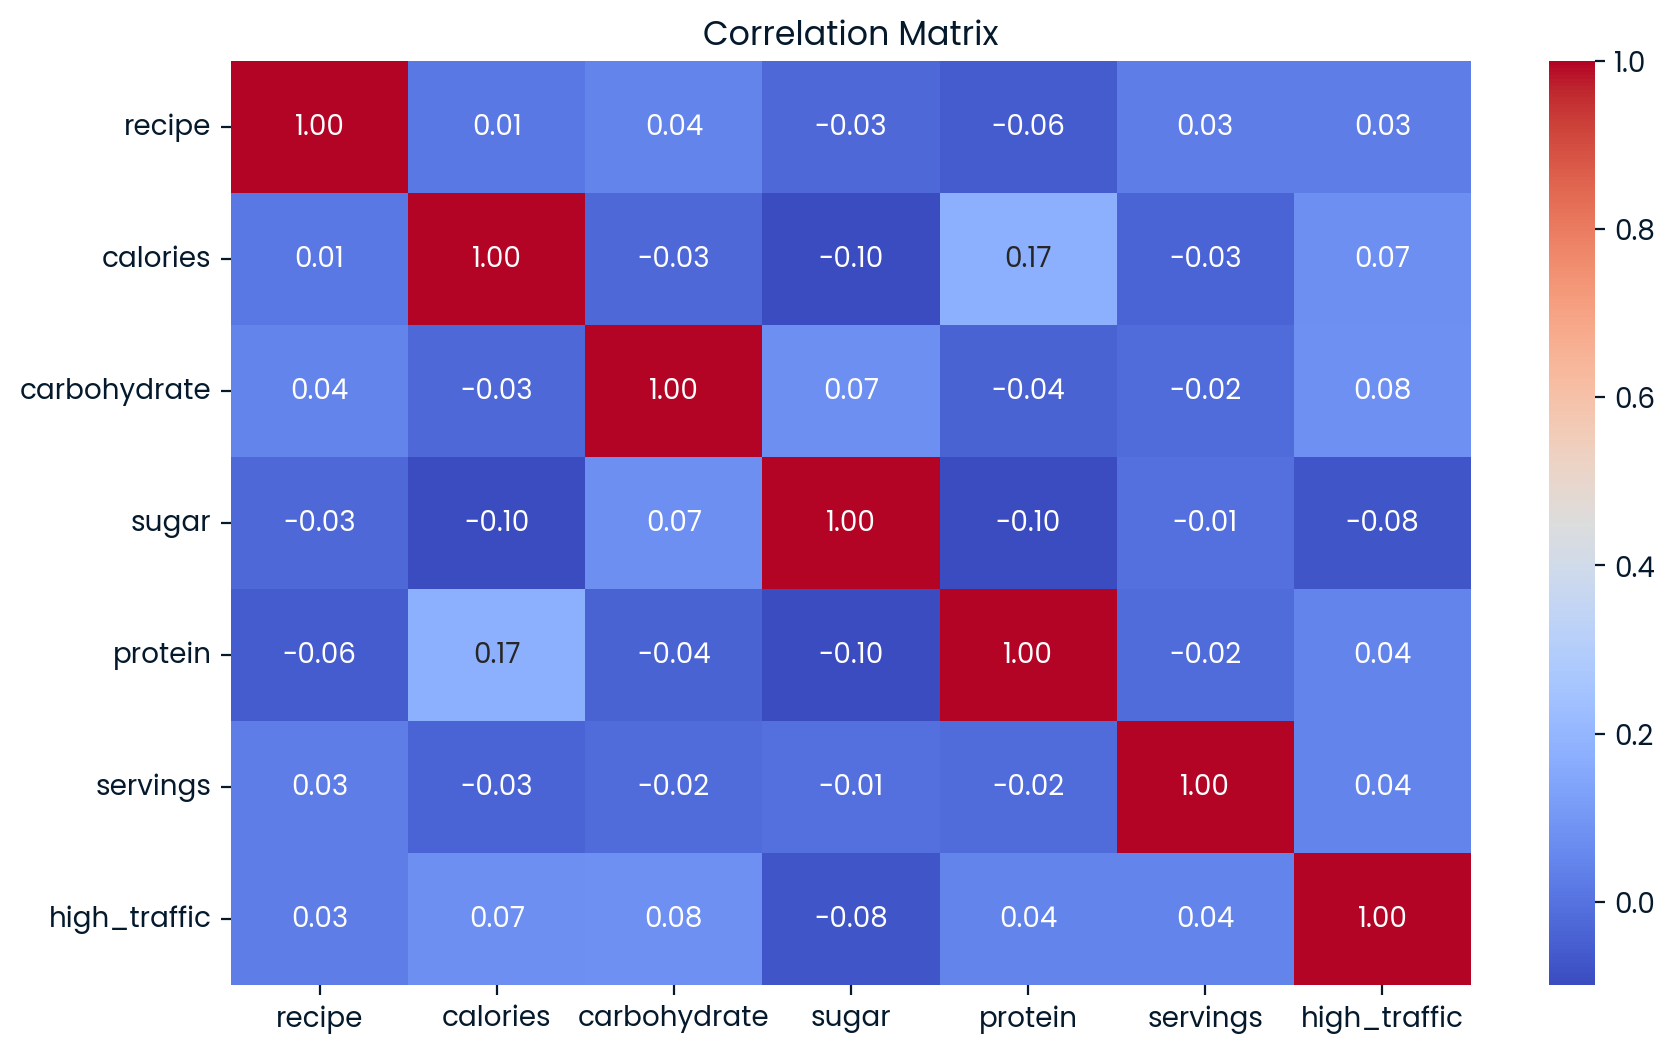

In [15]:
# Heatmap of correlation matrix
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Model Fitting and Evaluation

Predicting which recipes will lead to high traffic is a classification problem. Logistic Regression will be the base model as it is a simple, interpretable and computationally efficient algorithm. It will serve as a good baseline model to cocmpare more complex models against. Random Forest is the comparison model as it can capture non-linear relationships and interactions between features, which Logistic Regression cannot. Random Forest can also provide insights into feature importance, which can help understand which features contribute most to the prediction.

For evaluation, we will based on the classification reports and confusion matrices to select the model with the better performance.

In [16]:
# Feature engineering: convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['category'], drop_first=True)

# Define features X and target y
X = df.drop(columns=['high_traffic', 'recipe'], axis=1)
y = df['high_traffic']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression

In [17]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(C=0.1)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:")
print(accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression Accuracy:
0.7657992565055762
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       111
           1       0.79      0.82      0.80       158

    accuracy                           0.77       269
   macro avg       0.76      0.75      0.76       269
weighted avg       0.76      0.77      0.76       269

Logistic Regression Confusion Matrix:
[[ 76  35]
 [ 28 130]]


Random Forest

In [18]:
# Initialize the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:")
print(accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy:
0.724907063197026
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       111
           1       0.74      0.81      0.78       158

    accuracy                           0.72       269
   macro avg       0.72      0.71      0.71       269
weighted avg       0.72      0.72      0.72       269

Random Forest Confusion Matrix:
[[ 67  44]
 [ 30 128]]


## Performance Metrics and Evaluation

## Performance Metrics

1. Precision - Logistic Regression (Class 0: 0.73, Class 1: 0.79) has higher precision for both classes, meaning it makes fewer false positive predictions compared to Random Forest (Class 0: 0.69, Class 1: 0.74).
2. Recall - Logistic Regression has a slightly higher recall for Class 1 (0.82), suggesting it correctly identifies more instances of Class 1 compared to Random Forest (0.81). 
3. Accuracy (TP + TN / TP + FP + TN + FN) - Logistic Regression has higher accuracy (77%), meaning it correctly predicts more instances overall compared to Random Forest (72%).

## Performance Evaluation
The Logistic Regression model has fewer false positives and false negatives compared to Random Forest, indicating better performance in both classes. Based on business criteria, the Logistic Regression model is able to correctly predict high traffic recipes (Recall for Class 1) 82% of the time.

## Summary of Findings

- Logistic Regression outperforms Random Forest in terms of precision, recall, F1-score, and accuracy.

- Logistic Regression has fewer misclassifications (false positives and false negatives) compared to Random Forest.

- Random Forest, while still performing reasonably well, does not provide a significant improvement over Logistic Regression in this case. This could be due to the dataset’s characteristics (e.g., linear decision boundaries or fewer complex interactions between features).

- Logistic Regression is able to correctly predict high traffic recipes (Recall for Class 1) 82% of the time.

## Recommendations

- Adopt Logistic Regression as the primary model as it outperforms the Random Forest in terms of precision, recall and accuracy. It is more effective in predicting high-traffic recipes, and also has fewer misclassifications (false positives and false negatives), which reduces the risk of incorrect predictions.
- Explore feature engineering and tune hyperparameters for further improvements to the model. Test other models to ensure no better alternative exists.
- Continuously monitor model performance over time to ensure it remains effective as new data comes in. Track key metrics and detect any degradation in performance.
- Since model achieves 82% recall for high-traffic recipes (Class 1), the business can :
    - Prioritize marketing efforts for high-traffic recipes.
    - Optimize inventory management for ingredients used in these recipes.
    - Improve customer satisfaction by promoting popular recipes.